<a href="https://colab.research.google.com/github/GabrielFranciscoSM/Hojas_con_resfriado_placeholder/blob/main/notebooks/AppleTreeLeaf_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Apple Tree Leaf Disease

In [ ]:
from google.colab import drive
import os

# We start by getting access to the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Extracción de Bounding Boxes

En primer lugar tomaremos una muestra de una imágen junto a su correspondiente máscara de segmentación para determinar cómo extraer las _bounding boxes_

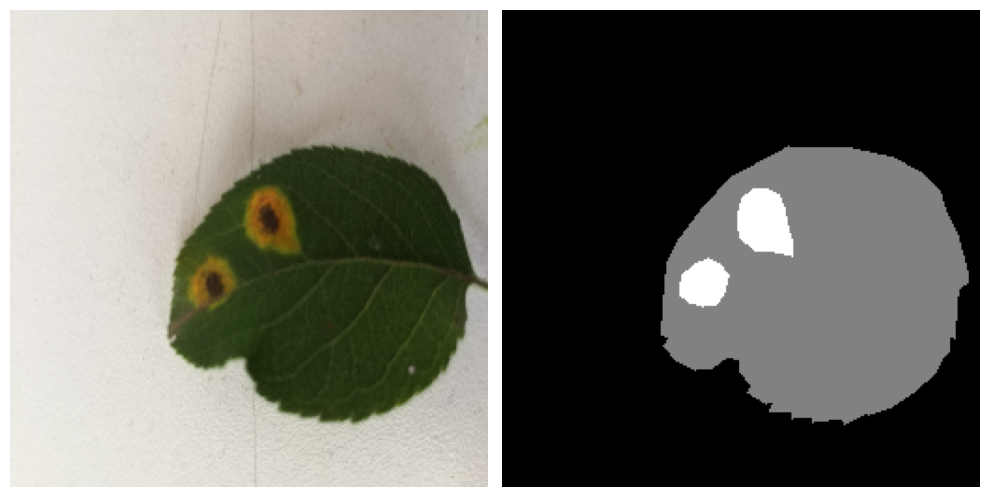

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

get_image = lambda route: os.path.join('/content/drive/MyDrive/AppleTreeLeafDisease', route)

img = cv2.imread(get_image("Rust/image/IMG_20190727_164455.jpg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(get_image("Rust/label/IMG_20190727_164455.png"))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.tight_layout()
plt.show()

A pesar de que existen varias alternativas optamos por utilizar exclusivamente la librería de OpenCV

In [ ]:
def extract_bounding_boxes(img, mask):
  # Retrieve the unique colors, as these would be the object ids
  obj_ids = np.unique(mask)

  # First id is the background, so remove it
  obj_ids = obj_ids[1:]

  boxes = []
  output_img = img.copy()

  for id in obj_ids:
    # Create binary mask for this specific class
    binary_mask = (mask == id).astype(np.uint8) * 255

    # Extract countours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
      # Get the box coordinates
      x, y, w, h = cv2.boundingRect(cnt)

      # Store them (optional, if you need the data)
      boxes.append([x, y, w, h])

      # Draw rectangle on image (Color: Red, Thickness: 2)
      cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

  return boxes, output_img

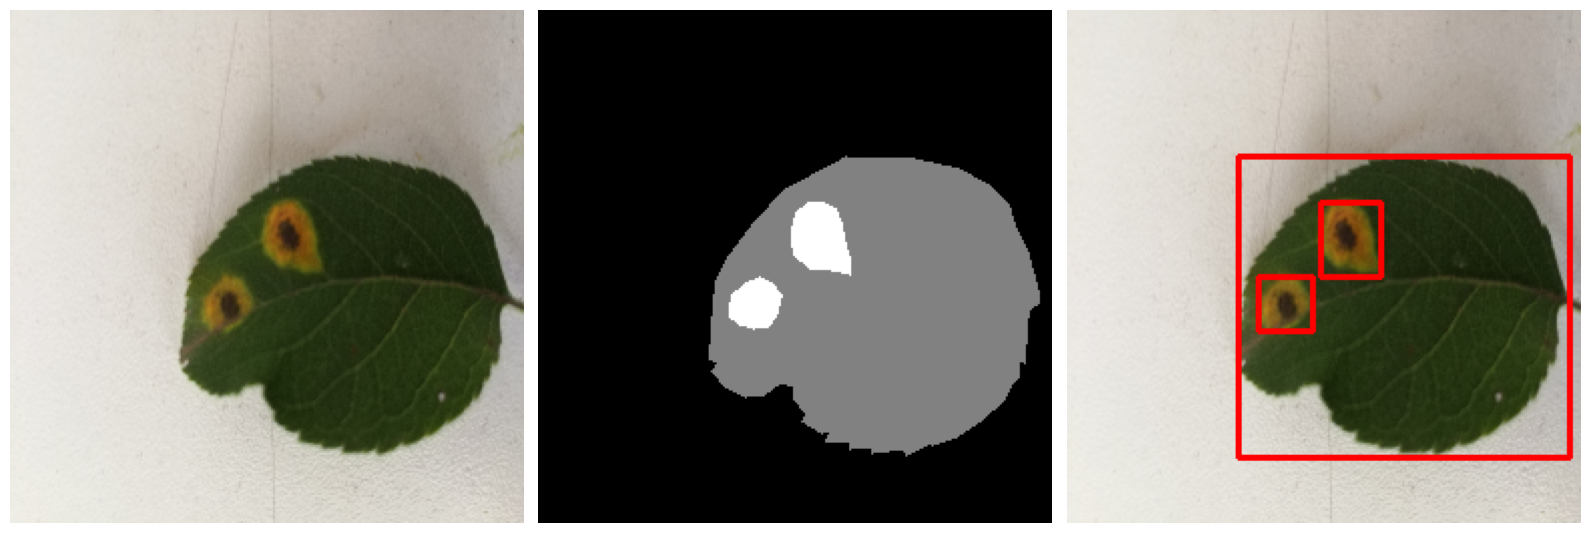

In [ ]:
bb, bb_img = extract_bounding_boxes(img, mask)

plt.figure(figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bb_img)
plt.axis('off')

plt.tight_layout()
plt.show()

Ya que la idea del proyecto es realizar la clasificación del tipo de planta de forma preliminar, solo nos hará falta las _bounding boxes_ de las posibles enfermedades. Para ello, vamos a tener que hacer uso de la codificación en colores que trae las máscaras puesto que, para hojas sanas, la codificación en blanco y negro induce a errores en la selección

In [ ]:
def visualize_rgb_bw_mask(img_path, mask_path):
  img = cv2.imread(get_image(img_path))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask = cv2.imread(get_image(mask_path))
  bw_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  rgb_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(10,10))
  plt.subplot(1, 3, 1)
  plt.imshow(img)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(rgb_mask)
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(bw_mask, cmap="gray")
  plt.axis('off')

  plt.tight_layout()
  plt.show()

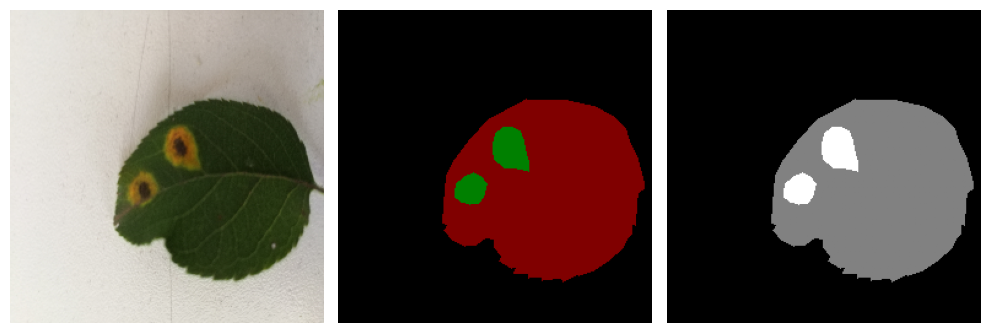

In [ ]:
visualize_rgb_bw_mask("Rust/image/IMG_20190727_164455.jpg", "Rust/label/IMG_20190727_164455.png")

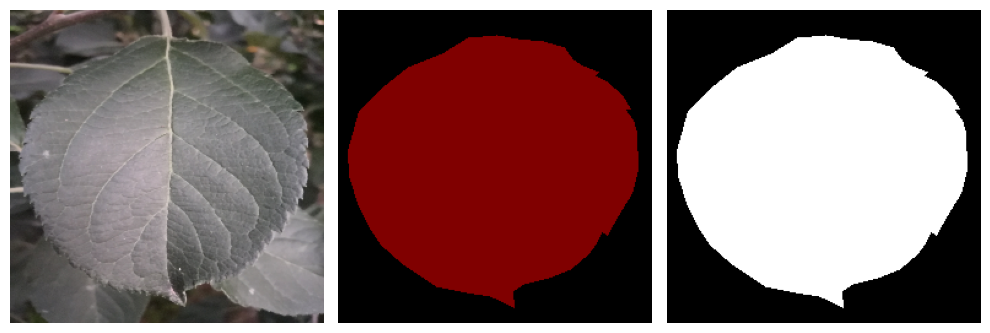

In [ ]:
visualize_rgb_bw_mask("Healthy_Leaf/image/IMG_20190726_200540.jpg", "Healthy_Leaf/label/IMG_20190726_200540.png")

Como se puede observar, en el caso de las hojas sanas, la codificación en RGB es consistente con la separación entre la hoja y la enfermedad, mientras que la codificación en BW no lo es. Para ello, optaremos por determinar los tres colores utilizados en la codificación RGB para seleccionar aquellas regiones con el color que nos interesa (en nuestro caso será el verde)

In [ ]:
mask = cv2.imread(get_image("Rust/label/IMG_20190727_164455.png"))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Reshape the 3D mask array (height, width, channels) to a 2D array (pixels, channels)
reshaped_mask = mask.reshape(-1, mask.shape[-1])

# Find unique rows (which are the unique RGB colors) along axis 0
unique_rgb_colors = np.unique(reshaped_mask, axis=0)

print(f"Unique RGB colors found in the mask:\n\n{unique_rgb_colors}")

Unique RGB colors found in the mask:

[[  0   0   0]
 [  0 128   0]
 [128   0   0]]


A continuación mostramos implementada una clase con todo el procesamiento de las imágenes.

In [ ]:
class ImageProcessor:
  def __init__(self):
    self.img = None

  def load_img(self, img_path):
    """
    Load image to paint bounding boxes in it
    """
    self.img = cv2.imread(img_path)
    self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

  def clean_mask(self, mask_path):
    """
    Extract disease binary mask from RGB mask.
    """
    mask_bgr = cv2.imread(mask_path)
    if mask_bgr is None:
      return None

    rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)

    # Background and Leaf colors
    black = np.array([0, 0, 0])
    red = np.array([128, 0, 0])

    # Extract masks for Background and Leaf sections
    mask_black = cv2.inRange(rgb, black, black)
    mask_red = cv2.inRange(rgb, red, red)

    # Extract the disease mask from those
    to_remove = cv2.bitwise_or(mask_black, mask_red)
    disease_mask = cv2.bitwise_not(to_remove)

    return disease_mask

  def get_bounding_boxes(self, binary_mask, class_id):
    """
    Compute YOLO bounding boxes from a binary mask.
    Returns a list of strings in the format: 'class_id x_norm y_norm w_norm h_norm'
    """
    img_h, img_w = binary_mask.shape

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    yolo_lines = []
    for cnt in contours:
      # Filter noise
      if cv2.contourArea(cnt) > 20:
        # Get the box coordinates
        x, y, w, h = cv2.boundingRect(cnt)

        if self.img is not None:
          # Draw rectangle on image (Color: Red, Thickness: 2)
          cv2.rectangle(self.img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Compute center
        center_x = x + (w / 2.0)
        center_y = y + (h / 2.0)

        # Normalize
        nx = center_x / img_w
        ny = center_y / img_h
        nw = w / img_w
        nh = h / img_h

        # Clamping
        nx = min(max(nx, 0), 1)
        ny = min(max(ny, 0), 1)
        nw = min(max(nw, 0), 1)
        nh = min(max(nh, 0), 1)

        # Format string
        line = f"{class_id} {nx:.6f} {ny:.6f} {nw:.6f} {nh:.6f}"
        yolo_lines.append(line)

    return yolo_lines

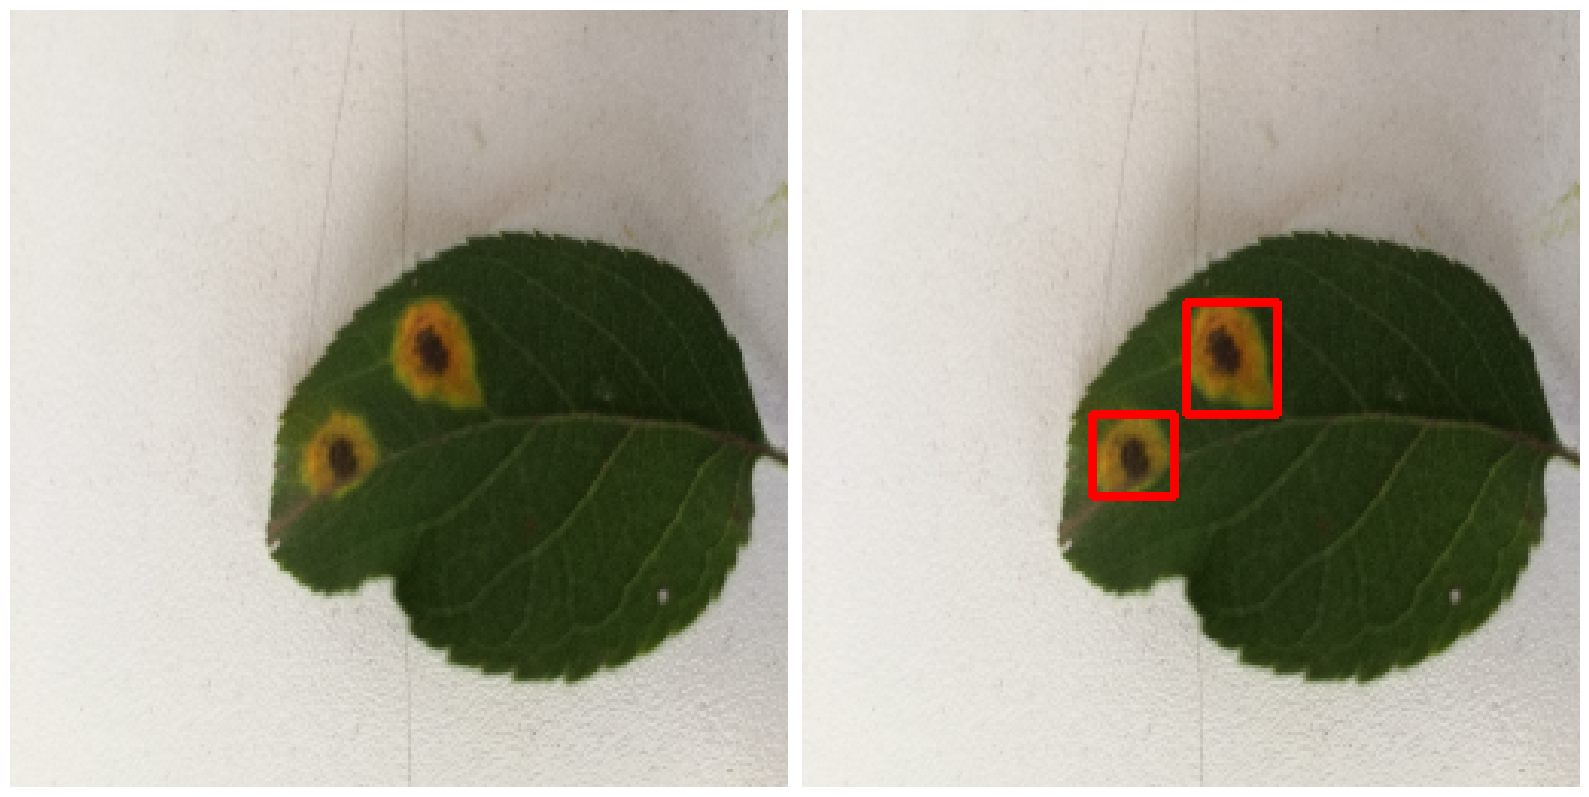

In [ ]:
processor = ImageProcessor()

# Load image into the processor
processor.load_img(get_image("Rust/image/IMG_20190727_164455.jpg"))

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(processor.img)
plt.axis('off')

# Get mask and compute the bounding boxes
mask = processor.clean_mask(get_image("Rust/label/IMG_20190727_164455.png"))
yolo = processor.get_bounding_boxes(mask, 0)

plt.subplot(1, 2, 2)
plt.imshow(processor.img)
plt.axis('off')

plt.tight_layout()
plt.show()

Dichos _bounding boxes_ tienen las siguientes coordenadas

In [ ]:
yolo

['0 0.423828 0.572266 0.105469 0.105469',
 '0 0.550781 0.447266 0.117188 0.144531']

### Exploración del Dataset

Seguidamente será necesario extraer tuplas de la forma `(class, img, mask)` de la estructura de directorios en la que está almacenado el _dataset_.

In [ ]:
from pathlib import Path

root = Path("/content/drive/MyDrive/AppleTreeLeafDisease")
valid_ext = [".jpg", ".png"]

dataset = []
classes = {}

# Each directory wraps a different disease
dirs = sorted([d for d in root.iterdir() if d.is_dir()])
for i, disease in enumerate(dirs):
  image_dir = disease / "image"
  mask_dir = disease / "label"

  # Check if both subdirectories exist
  if image_dir.exists() and mask_dir.exists():

    # Add disease to the class list
    classes[disease.name] = i

    # Extract images and masks
    images = sorted([f for f in image_dir.iterdir() if f.suffix.lower() in valid_ext])
    masks = sorted([f for f in mask_dir.iterdir() if f.suffix.lower() in valid_ext])

    # Dictionary of masks for fast lookup by filename
    mask_dict = {mask.stem: mask for mask in masks}

    for image_path in images:
      # Check if a label with the same name exists
      if image_path.stem in mask_dict:
        dataset.append((i, image_path, mask_dict[image_path.stem]))
      else:
        print(f"No mask found for {image_path.stem}")

print(f"Found {len(dataset)} pairs.")

Found 1641 pairs.


De esta forma hemos obtenido $1641$ tuplas de las siguientes clases

In [ ]:
classes

{'Alternaria_Leaf_Spot': 0,
 'Brown_Spot': 1,
 'Gray_Spot': 2,
 'Healthy_Leaf': 3,
 'Rust': 4}

Así, podemos automatizar la extracción de las _bounding boxes_

In [ ]:
from random import sample

def show_sample(dataset_pairs, n):
  samples = sample(dataset_pairs, n)

  fig, axs = plt.subplots(n, 3, figsize=(6, 10))

  for i, (class_id, img_path, mask_path) in enumerate(samples):
    processor = ImageProcessor()
    processor.load_img(img_path)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    cleaned_mask = processor.clean_mask(mask_path)
    yolo = processor.get_bounding_boxes(cleaned_mask, class_id)

    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask)
    axs[i, 1].axis('off')

    axs[i, 2].imshow(processor.img)
    axs[i, 2].axis('off')

  plt.tight_layout()
  plt.show()

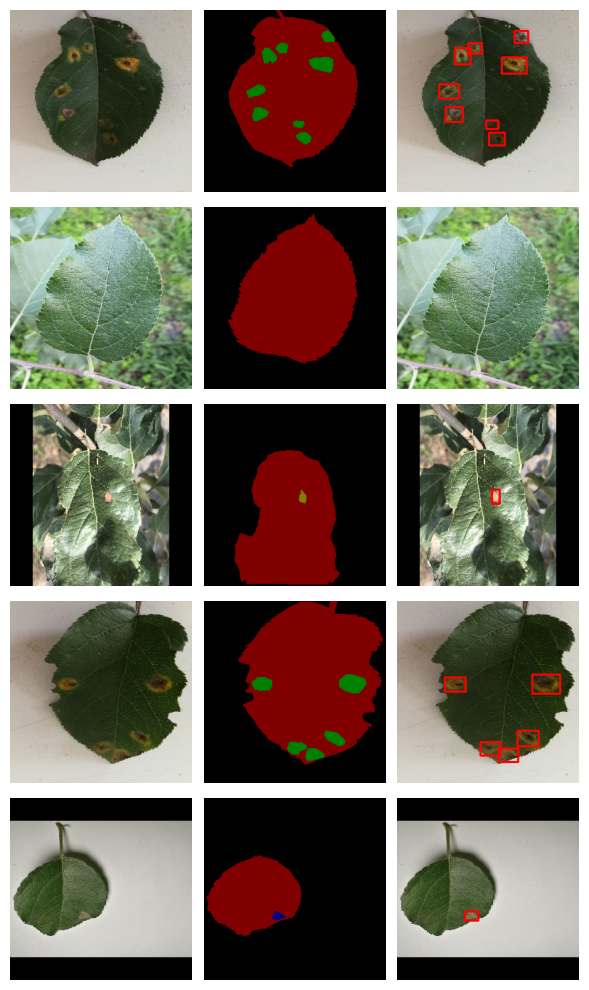

In [ ]:
show_sample(dataset, 5)

### Reestructuración de directorios para YOLO

Para cada imagen necesitaremos guardar un archivo `.txt` con las respectivas _bounding boxes_ encontradas. Además, la implementación de YOLO requiere tanto que separemos previamente las imágenes en dos directorios (`train`, `test`) como un archivo `.yaml` donde se especifican el número de clases, los nombres de las clases y las rutas a los directorios de entrenamiento/test.

Unificaremos todas estas utilidades bajo la clase `DatasetBuilder`

In [ ]:
import shutil
import yaml

class DatasetBuilder:
  def __init__(self, output_path):
    self.output_path = output_path
    self.processor = ImageProcessor()
    self.classes = {}

  def prepare_directories(self):
    """
    Creates the directory structure for YOLO
    """

    # If it already exist delete it
    if os.path.exists(self.output_path):
      shutil.rmtree(self.output_path)

    for split in ['train', 'val']:
      os.makedirs(f"{self.output_path}/{split}/images", exist_ok=True)
      os.makedirs(f"{self.output_path}/{split}/labels", exist_ok=True)

  def scan_dataset(self, source_root):
    """
    Scans the whole dataset and extracts the classes, images and masks
    """
    dataset = []

    # Each directory wraps a different disease
    dirs = sorted([d for d in source_root.iterdir() if d.is_dir()])
    for i, disease in enumerate(dirs):
      image_dir = disease / "image"
      mask_dir = disease / "label"

      # Check if both subdirectories exist
      if image_dir.exists() and mask_dir.exists():

        # Add disease to the class list
        self.classes[disease.name] = i

        # Extract images and masks
        images = sorted([f for f in image_dir.iterdir() if f.is_file()])
        masks = sorted([f for f in mask_dir.iterdir() if f.is_file()])

        # Dictionary of masks for fast lookup by filename
        mask_dict = {mask.stem: mask for mask in masks}

        for image_path in images:
          # Check if a label with the same name exists
          if image_path.stem in mask_dict:
            dataset.append((i, image_path, mask_dict[image_path.stem]))
          else:
            print(f"[!] No mask found for {image_path.stem}")

    print(f"[+] Found {len(self.classes)} classes and {len(dataset)} images")
    return dataset

  def process_subset(self, subset, split):
    """
    Processes a subset (train or val) and saves the YOLO file
    """
    print(f"[+] Processing {split.upper()} containing {len(subset)} images...")

    count = 0
    for class_id, img_path, mask_path in subset:
      # Copy the original image into the destination directory
      dst_img_path = self.output_path / split / "images" / img_path.name
      shutil.copy(img_path, dst_img_path)

      # Process mask
      cleaned_mask = self.processor.clean_mask(mask_path)

      if cleaned_mask is not None:
        # Obtain bounding boxes
        yolo_lines = self.processor.get_bounding_boxes(cleaned_mask, class_id)

        # Save .txt file for YOLO
        dst_txt_name = img_path.stem + ".txt"
        dst_txt_path = self.output_path / split / "labels" / dst_txt_name

        with open(dst_txt_path, 'w') as f:
          for line in yolo_lines:
            f.write(line + '\n')

        count += 1
      else:
        print(f"[!] No mask found for {img_path.stem}")

    print(f"[+] Processed {count} images in {split.upper()}")

  def create_yaml(self):
    """
    Generates the data.yaml file needed for YOLO
    """
    yaml_data = {
        "path": str(self.output_path),
        "train": "train/images",
        "val": "val/images",
        "nc": len(self.classes),
        "names": list(self.classes.keys())
    }
    with open(self.output_path / "data.yaml", 'w') as f:
      yaml.dump(yaml_data, f, sort_keys=False)

    print(f"[+] Configuration file created at {self.output_path}/data.yaml")


A continuación crearemos una nueva estructura de directorios temporal donde alojaremos el _dataset_ preparado para aplicar YOLO

In [ ]:
from sklearn.model_selection import train_test_split

# Route of the dataset
SOURCE_PATH = Path("/content/drive/MyDrive/AppleTreeLeafDisease")

# Local route for the YOLO adapted dataset
LOCAL_OUTPUT_PATH = Path("/content/AppleTreeLeafDisease_YOLO")

# Drive route for the YOLO adapted dataset
DRIVE_OUTPUT_PATH = Path("/content/drive/MyDrive/AppleTreeLeafDisease_YOLO")

# Create builder with that route as root
builder = DatasetBuilder(LOCAL_OUTPUT_PATH)

try:
  print(f"[+] Generating local dataset in {LOCAL_OUTPUT_PATH}")

  # Create local directories
  builder.prepare_directories()

  # Scan dataset
  dataset = builder.scan_dataset(SOURCE_PATH)

  # Divide images
  train_imgs, val_imgs = train_test_split(dataset, test_size=0.2, random_state=42)

  # Process each batch of images
  builder.process_subset(train_imgs, 'train')
  builder.process_subset(val_imgs, 'val')

  # Create configuration file
  builder.create_yaml()

  # Copies the whole directory structure into our Drive
  #shutil.copytree(LOCAL_OUTPUT_PATH, DRIVE_OUTPUT_PATH)

  print("[+] Dataset generated successfully!")
except Exception as e:
  print(f"\n\n[!] Error: {e}")

[+] Generating local dataset in /content/AppleTreeLeafDisease_YOLO
[+] Found 5 classes and 1641 images
[+] Processing TRAIN containing 1312 images...
[+] Processed 1312 images in TRAIN
[+] Processing VAL containing 329 images...
[+] Processed 329 images in VAL
[+] Configuration file created at /content/AppleTreeLeafDisease_YOLO/data.yaml
[+] Dataset generated successfully!


### YOLO

Ya estamos en condiciones de empezar a implementar un flujo de trabajo con YOLO. Comenzaremos instalando la biblioteca de `ultralytics` que se trata de una empresa dedicada a mantener e implementar versiones modernas de YOLO

In [ ]:
!pip install -Uqq ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

DATASET_PATH = Path("/content/AppleTreeLeafDisease_YOLO")
YAML_PATH = DATASET_PATH / "data.yaml"

if not DATASET_PATH.exists():
    print(f"[!] Error: Configuration file not found in {YAML_PATH}")

# Load a pretrained YOLO model
model = YOLO('yolov8n.pt')

# Train the model for 3 epochs
results = model.train(
    data=YAML_PATH,
    epochs=50,
    imgsz=640,
    batch=16
)

# Evaluate the model's performance on the validation set
metrics = model.val()

In [ ]:
from IPython.display import Image, display

# Ajusta la ruta si cambiaste el nombre en model.train(name='...')
Image(filename='runs/detect/train/results.png')

### Seguir aqui

## Leer de drive los datos


<>:64: SyntaxWarning: invalid escape sequence '\ '
<>:64: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-845130491.py:64: SyntaxWarning: invalid escape sequence '\ '
  print("\ COMPARATIVA VISUAL (Original vs Label)")


Dataset localizado en: /content/drive/MyDrive/Colab Notebooks/AppleTreeLeafDisease

 RECUENTO DE IMÁGENES POR CLASE
    Clase: 'Rust' -> 344 fotos.
    Clase: 'Gray_Spot' -> 395 fotos.
    Clase: 'Brown_Spot' -> 215 fotos.
    Clase: 'Alternaria_Leaf_Spot' -> 278 fotos.
    Clase: 'Healthy_Leaf' -> 409 fotos.


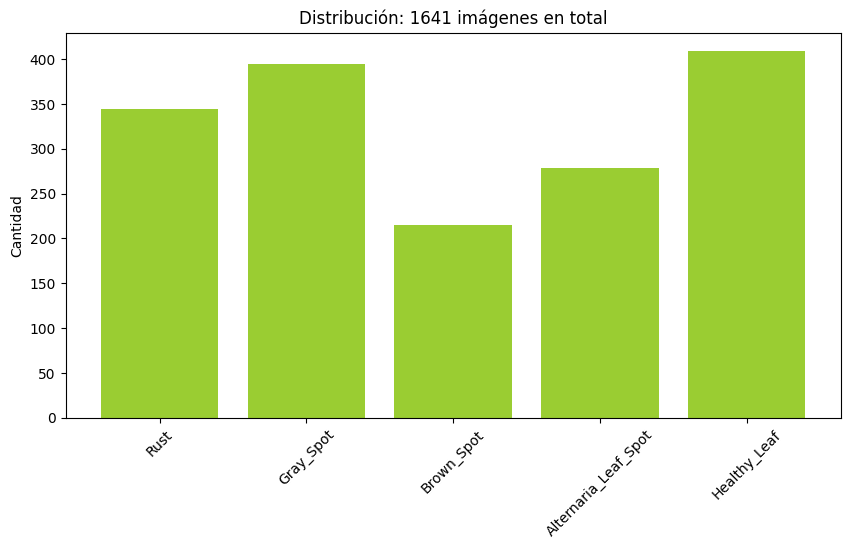

\ COMPARATIVA VISUAL (Original vs Label)


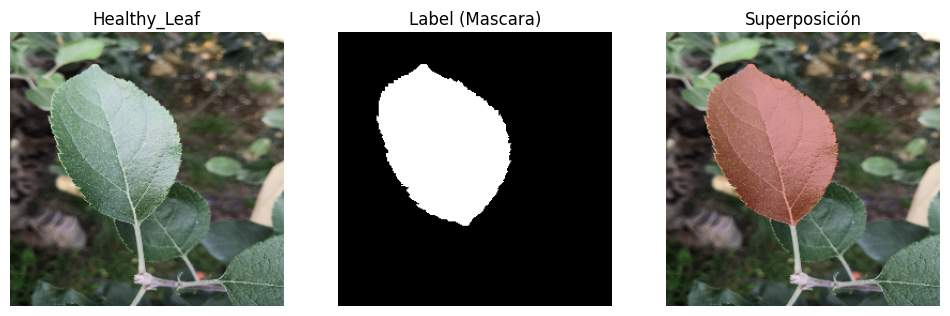

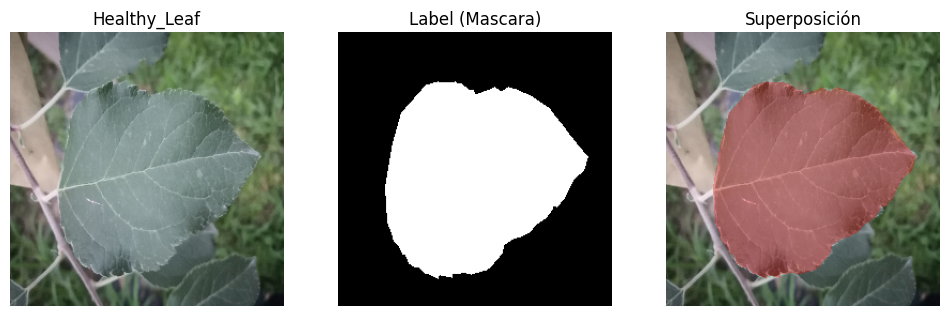

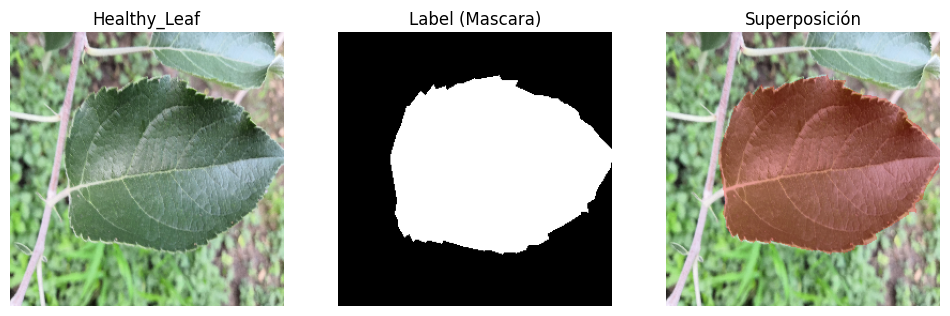

In [ ]:
from google.colab import drive
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

# 1. MONTAR DRIVE
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. LOCALIZAR DATASET
search_path = "/content/drive/MyDrive"
# Buscamos la carpeta raiz del dataset
candidates = glob.glob(f'{search_path}/**/AppleTreeLeafDisease', recursive=True)

if not candidates:
    print("ERROR: No encuentro la carpeta 'AppleTreeLeafDisease'.")
    dataset_root = None
else:
    dataset_root = candidates[0]
    print(f"Dataset localizado en: {dataset_root}")

if dataset_root:
    # 3. ANÁLISIS DE CLASES (CONTANDO ARCHIVOS)
    print("\n RECUENTO DE IMÁGENES POR CLASE")

    classes_found = {}

    # Recorremos todas las carpetas
    for root, dirs, files in os.walk(dataset_root):
        # BUSCAMOS LA CARPETA EXACTA "image" (Singular)
        if 'image' in dirs:
            # El nombre de la enfermedad es la carpeta donde estamos ahora
            disease_name = os.path.basename(root)

            # Ruta completa a las imágenes
            img_dir = os.path.join(root, 'image')

            # Contamos archivos
            images = glob.glob(f"{img_dir}/*.jpg") + \
                     glob.glob(f"{img_dir}/*.png") + \
                     glob.glob(f"{img_dir}/*.jpeg") + \
                     glob.glob(f"{img_dir}/*.JPG") # Por si acaso mayúsculas

            if len(images) > 0:
                classes_found[disease_name] = images
                print(f"    Clase: '{disease_name}' -> {len(images)} fotos.")

    # 4. GRÁFICO (HISTOGRAMA)
    if classes_found:
        names = list(classes_found.keys())
        counts = [len(v) for v in classes_found.values()]

        plt.figure(figsize=(10, 5))
        plt.bar(names, counts, color='yellowgreen')
        plt.title(f"Distribución: {sum(counts)} imágenes en total")
        plt.ylabel("Cantidad")
        plt.xticks(rotation=45)
        plt.show()

        # 5. VISUALIZACIÓN (FOTO vs MÁSCARA)
        print("\ COMPARATIVA VISUAL (Original vs Label)")

        # Elegimos clase aleatoria
        rnd_cls = random.choice(list(classes_found.keys()))
        img_list = classes_found[rnd_cls]

        # Mostramos 3 ejemplos
        samples = random.sample(img_list, min(len(img_list), 3))

        for i, img_path in enumerate(samples):
            # Leer imagen original
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


            # 1. Determinar carpeta de labels
            # Si la ruta es .../Rust/image/foto.jpg -> .../Rust/label/
            label_dir = os.path.dirname(img_path).replace('/image', '/label')

            # 2. Nombre del archivo (sin extensión)
            base_name = os.path.splitext(os.path.basename(img_path))[0]

            # 3. Buscar archivo en la carpeta label (puede ser .png aunque la foto sea .jpg)
            mask_path = None
            candidates_mask = glob.glob(f"{label_dir}/{base_name}.*")
            if candidates_mask:
                mask_path = candidates_mask[0]

            # --- DIBUJAR ---
            plt.figure(figsize=(12, 4))

            # Original
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"{rnd_cls}")
            plt.axis('off')

            if mask_path and os.path.exists(mask_path):
                # Leer Máscara
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                # Máscara Sola
                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap='gray')
                plt.title("Label (Mascara)")
                plt.axis('off')

                # Superposición
                # Redimensionar si es necesario
                if mask.shape != img.shape[:2]:
                    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

                overlay = img.copy()
                # Pintar de rojo donde la máscara no sea negra (valor > 0)
                overlay[mask > 0] = [255, 0, 0]

                combined = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

                plt.subplot(1, 3, 3)
                plt.imshow(combined)
                plt.title("Superposición")
                plt.axis('off')
            else:
                plt.subplot(1, 3, 2)
                plt.text(0.5, 0.5, "SIN LABEL", ha='center')
                plt.title("Carpeta 'label' no encontrada o vacía")
                plt.axis('off')

            plt.show()

    else:
        print(" No encontré carpetas llamadas 'image'. Revisa si están escritas en minúsculas.")

## Funciones de Procesamiento

In [ ]:
import cv2
import numpy as np

class ImageProcessor:
    """
    Clase encargada de las operaciones matemáticas sobre las imágenes:
    - Limpieza de máscaras (RGB -> Binaria)
    - Cálculo de Bounding Boxes (Binaria -> YOLO Cuadrado)
    """

    def clean_mask(self, mask_path):
        """Lee una máscara RGB y devuelve una máscara binaria limpia."""
        mask_bgr = cv2.imread(mask_path)
        if mask_bgr is None: return None

        # 1. Convertir a HSV
        hsv = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2HSV)

        # 2. Definir rangos de colores a eliminar (Fondo Negro y Hoja Sana Roja)
        lower_black = np.array([0, 0, 0])
        upper_black = np.array([180, 255, 60])
        mask_black = cv2.inRange(hsv, lower_black, upper_black)

        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])

        lower_red2 = np.array([170, 50, 50])
        upper_red2 = np.array([180, 255, 255])
        mask_red = cv2.bitwise_or(cv2.inRange(hsv, lower_red1, upper_red1), cv2.inRange(hsv, lower_red2, upper_red2))

        # 3. Combinar y limpiar
        to_remove = cv2.bitwise_or(mask_black, mask_red)
        disease_mask = cv2.bitwise_not(to_remove)

        # 4. Eliminar ruido (puntos pequeños)
        kernel = np.ones((3,3), np.uint8)
        disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_OPEN, kernel, iterations=1)

        return disease_mask

    def get_square_yolo_boxes(self, binary_mask, class_id, img_w, img_h):
        """
        Analiza la máscara binaria y devuelve una lista de strings en formato YOLO:
        'class_id x_norm y_norm w_norm h_norm'
        """
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        yolo_lines = []

        for cnt in contours:
            if cv2.contourArea(cnt) > 20: # Filtro de área mínima
                # A. Obtener rectángulo base
                x, y, w, h = cv2.boundingRect(cnt)

                # B. Convertir a CUADRADO
                center_x = x + w // 2
                center_y = y + h // 2
                side = max(w, h) # Usamos el lado más largo

                # C. Normalizar (0.0 a 1.0)
                nx = center_x / img_w
                ny = center_y / img_h
                nw = side / img_w
                nh = side / img_h

                # D. Validar límites (Clamping)
                nx = min(max(nx, 0), 1); ny = min(max(ny, 0), 1)
                nw = min(max(nw, 0), 1); nh = min(max(nh, 0), 1)

                # E. Formatear string
                line = f"{class_id} {nx:.6f} {ny:.6f} {nw:.6f} {nh:.6f}"
                yolo_lines.append(line)

        return yolo_lines

## El Gestor del Dataset

In [ ]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

class DatasetBuilder:
    """
    Clase encargada de la gestión de archivos y estructura de directorios.
    """
    def __init__(self, output_path):
        self.output_path = output_path
        self.processor = ImageProcessor() # Instancia de la clase anterior
        self.classes = {}

    def prepare_directories(self):
        """Borra (si existe) y crea la estructura de carpetas YOLO."""
        if os.path.exists(self.output_path):
            shutil.rmtree(self.output_path)

        for split in ['train', 'val']:
            os.makedirs(f"{self.output_path}/{split}/images", exist_ok=True)
            os.makedirs(f"{self.output_path}/{split}/labels", exist_ok=True)
        print(f" Estructura de carpetas creada en: {self.output_path}")

    def scan_dataset(self, source_root):
        """Escanea Drive buscando clases e imágenes."""
        print("Escaneando origen de datos...")
        candidates = glob.glob(f'{source_root}/**/AppleTreeLeafDisease', recursive=True)
        if not candidates:
            raise Exception(" No se encontró la carpeta 'AppleTreeLeafDisease'.")

        root_folder = candidates[0]
        images_found = []
        class_names = set()

        # Recorrer carpetas
        for root, dirs, files in os.walk(root_folder):
            if 'image' in dirs:
                c_name = os.path.basename(root)
                class_names.add(c_name)
                # Buscar fotos
                imgs = glob.glob(f"{root}/image/*.jpg") + glob.glob(f"{root}/image/*.png")
                for i in imgs:
                    images_found.append((i, c_name))

        # Crear mapa de IDs (Rust=0, Scab=1, etc.)
        self.classes = {name: i for i, name in enumerate(sorted(list(class_names)))}
        print(f" Clases detectadas: {self.classes}")
        return images_found

    def process_subset(self, image_list, split_name):
        """Procesa una lista de imágenes (train o val) y las guarda."""
        print(f" Procesando {split_name.upper()} ({len(image_list)} imágenes)...")
        count = 0

        for img_path, class_name in image_list:
            # 1. Leer imagen original
            img = cv2.imread(img_path)
            if img is None: continue
            h, w = img.shape[:2]

            # 2. Buscar ruta de la máscara
            label_dir = os.path.dirname(img_path).replace('/image', '/label')
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            mask_candidates = glob.glob(f"{label_dir}/{base_name}.*")

            if mask_candidates:
                # 3. USAR EL PROCESADOR (Bloque 1)
                # Limpiar
                mask = self.processor.clean_mask(mask_candidates[0])
                if mask is None: continue

                # Obtener cajas
                class_id = self.classes[class_name]
                yolo_data = self.processor.get_square_yolo_boxes(mask, class_id, w, h)

                # 4. Guardar SOLO si hay cajas válidas
                if yolo_data:
                    # Guardar imagen JPG
                    dest_img = f"{self.output_path}/{split_name}/images/{base_name}.jpg"
                    cv2.imwrite(dest_img, img)

                    # Guardar label TXT
                    dest_txt = f"{self.output_path}/{split_name}/labels/{base_name}.txt"
                    with open(dest_txt, 'w') as f:
                        f.write('\n'.join(yolo_data))
                    count += 1

        print(f"{count} imágenes guardadas en {split_name}.")

    def create_yaml(self):
        """Genera el archivo data.yaml necesario para YOLO."""
        yaml_content = f"""
path: {self.output_path}
train: train/images
val: val/images

nc: {len(self.classes)}
names: {list(self.classes.keys())}
"""
        with open(f"{self.output_path}/data.yaml", 'w') as f:
            f.write(yaml_content)
        print(" Archivo 'data.yaml' generado.")

## Ejecución

In [ ]:
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split

# 1. Configuración
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

SOURCE_PATH = "/content/drive/MyDrive"

# --- ESTRATEGIA HÍBRIDA ---
# A. Ruta RÁPIDA (Disco temporal de Colab)
LOCAL_OUTPUT_PATH = "/content/yolo_dataset_structured"

# B. Ruta SEGURA (Tu Google Drive)
DRIVE_OUTPUT_PATH = "/content/drive/MyDrive/yolo_dataset_structured"

# 2. Inicializar el Constructor apuntando al DISCO LOCAL (Velocidad)
builder = DatasetBuilder(LOCAL_OUTPUT_PATH)

# 3. Pasos de ejecución
try:
    print(f" Generando dataset en disco local (Rápido): {LOCAL_OUTPUT_PATH}")

    # A. Preparar carpetas locales
    builder.prepare_directories()

    # B. Buscar imágenes
    all_images = builder.scan_dataset(SOURCE_PATH)

    # C. Dividir Train/Val
    train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

    # D. Procesar cada lote (Esto irá muy rápido al ser local)
    builder.process_subset(train_imgs, 'train')
    builder.process_subset(val_imgs, 'val')

    # E. Crear configuración
    builder.create_yaml()

    print("\n Dataset generado correctamente en local.")

    # ---------------------------------------------------------
    # 4. COPIAR A GOOGLE DRIVE (BACKUP)
    # ---------------------------------------------------------
    print(f"\n Iniciando respaldo en Google Drive: {DRIVE_OUTPUT_PATH} ...")
    print("   (Esto puede tardar un poco dependiendo de la cantidad de fotos, ten paciencia)")

    # Si la carpeta ya existe en Drive, la borramos para evitar mezclas
    if os.path.exists(DRIVE_OUTPUT_PATH):
        shutil.rmtree(DRIVE_OUTPUT_PATH)

    # Copiar todo el directorio local al Drive
    shutil.copytree(LOCAL_OUTPUT_PATH, DRIVE_OUTPUT_PATH)

    print("\n ¡PROCESO FINALIZADO CON ÉXITO!")
    print(f"1. Disponible para entrenar YA en: {LOCAL_OUTPUT_PATH}")
    print(f"2. Guardado para el futuro en:     {DRIVE_OUTPUT_PATH}")

except Exception as e:
    print(f"\n Ocurrió un error: {e}")

 Generando dataset en disco local (Rápido): /content/yolo_dataset_structured
 Estructura de carpetas creada en: /content/yolo_dataset_structured
Escaneando origen de datos...
 Clases detectadas: {'Alternaria_Leaf_Spot': 0, 'Brown_Spot': 1, 'Gray_Spot': 2, 'Healthy_Leaf': 3, 'Rust': 4}
 Procesando TRAIN (962 imágenes)...
594 imágenes guardadas en train.
 Procesando VAL (241 imágenes)...
155 imágenes guardadas en val.
 Archivo 'data.yaml' generado.

 Dataset generado correctamente en local.

 Iniciando respaldo en Google Drive: /content/drive/MyDrive/yolo_dataset_structured ...
   (Esto puede tardar un poco dependiendo de la cantidad de fotos, ten paciencia)

 ¡PROCESO FINALIZADO CON ÉXITO!
1. Disponible para entrenar YA en: /content/yolo_dataset_structured
2. Guardado para el futuro en:     /content/drive/MyDrive/yolo_dataset_structured


## Visualizacion

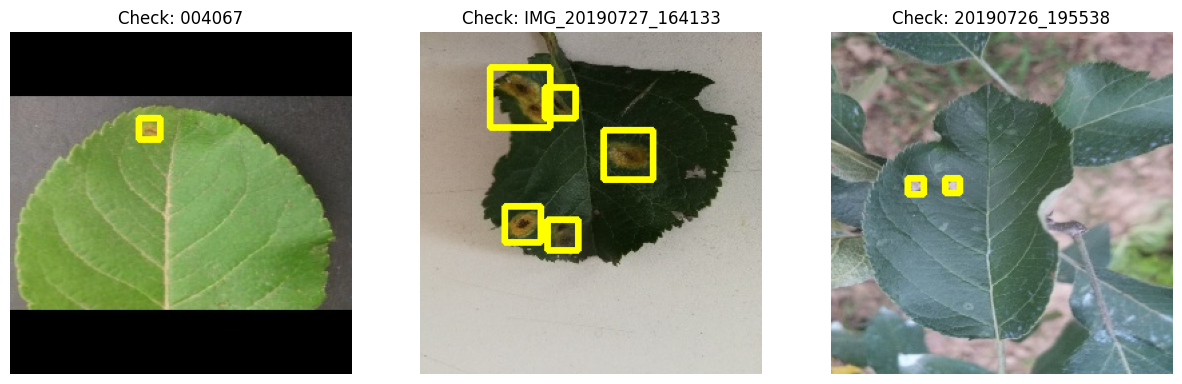

In [ ]:
import matplotlib.pyplot as plt
import random

def verify_dataset(dataset_path):
    """Toma 3 imágenes aleatorias del dataset generado y dibuja las cajas."""
    img_dir = f"{dataset_path}/train/images"
    lbl_dir = f"{dataset_path}/train/labels"

    images = glob.glob(f"{img_dir}/*.jpg")
    if not images:
        print(" No hay imágenes para verificar.")
        return

    samples = random.sample(images, min(len(images), 3))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(samples):
        # Leer imagen y label
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        base_name = os.path.splitext(os.path.basename(img_path))[0]
        txt_path = f"{lbl_dir}/{base_name}.txt"

        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    # Parsear YOLO
                    parts = list(map(float, line.split()))
                    # Des-normalizar para pintar
                    cx, cy, nw, nh = parts[1], parts[2], parts[3], parts[4]
                    x1 = int((cx - nw/2) * w)
                    y1 = int((cy - nh/2) * h)
                    x2 = int((cx + nw/2) * w)
                    y2 = int((cy + nh/2) * h)
                    # Dibujar
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 3)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Check: {base_name}")
    plt.show()

# Ejecutar verificación
verify_dataset(LOCAL_OUTPUT_PATH)

## PRUEBAS YOLO

### PRUEBA 30% del Dataset

In [ ]:
import os
import shutil
import glob
import random
import yaml
from sklearn.model_selection import train_test_split
from google.colab import drive

# Aseguramos que Drive esté montado
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


# ==========================================
# CONFIGURACIÓN DE RUTAS
# ==========================================
# 1. Origen (Local para velocidad)
ORIGINAL_PATH = "/content/yolo_dataset_structured"

# 2. Destino RÁPIDO (Disco Local - Aquí entrenarás)
MINI_PATH_LOCAL = "/content/yolo_mini"

# 3. Destino SEGURO (Drive - Aquí se guarda para siempre)
MINI_PATH_DRIVE = "/content/drive/MyDrive/yolo_mini"

FRACTION = 0.3  # 30% de los datos

# ==========================================
# EJECUCIÓN
# ==========================================

# 1. Limpiar/Crear carpetas en LOCAL
if os.path.exists(MINI_PATH_LOCAL): shutil.rmtree(MINI_PATH_LOCAL)

for split in ['train', 'val']:
    os.makedirs(f"{MINI_PATH_LOCAL}/{split}/images", exist_ok=True)
    os.makedirs(f"{MINI_PATH_LOCAL}/{split}/labels", exist_ok=True)

# 2. Función de Muestreo y Copia (TRABAJA EN LOCAL)
def create_subset(split_name):
    img_dir = os.path.join(ORIGINAL_PATH, split_name, 'images')
    lbl_dir = os.path.join(ORIGINAL_PATH, split_name, 'labels')

    # Listar imágenes
    images = glob.glob(f"{img_dir}/*.jpg") + glob.glob(f"{img_dir}/*.png")

    # Tomar muestra aleatoria
    if len(images) > 0:
        sample_size = int(len(images) * FRACTION)
        sample_size = max(sample_size, 10)
        subset = random.sample(images, min(len(images), sample_size))

        print(f"     {split_name}: Copiando {len(subset)} de {len(images)} imágenes al disco local...")

        for img_path in subset:
            # Copiar Imagen a LOCAL
            shutil.copy(img_path, f"{MINI_PATH_LOCAL}/{split_name}/images/")

            # Copiar Label correspondiente a LOCAL
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            txt_path = os.path.join(lbl_dir, base_name + ".txt")
            if os.path.exists(txt_path):
                shutil.copy(txt_path, f"{MINI_PATH_LOCAL}/{split_name}/labels/")
            else:
                 # Crear vacío si es sana
                 open(f"{MINI_PATH_LOCAL}/{split_name}/labels/{base_name}.txt", 'w').close()
    else:
        print(f"     No hay imágenes en {split_name}.")

# Ejecutamos la creación en disco local (¡Muy rápido!)
create_subset('train')
create_subset('val')

# 3. Crear data.yaml en LOCAL
if os.path.exists(f"{ORIGINAL_PATH}/data.yaml"):
    with open(f"{ORIGINAL_PATH}/data.yaml", 'r') as f:
        old_yaml = yaml.safe_load(f)

    # NOTA: En el yaml ponemos la ruta LOCAL, para que el entrenamiento sea veloz
    new_yaml = {
        'path': MINI_PATH_LOCAL,
        'train': 'train/images',
        'val': 'val/images',
        'nc': old_yaml['nc'],
        'names': old_yaml['names']
    }

    with open(f"{MINI_PATH_LOCAL}/data.yaml", 'w') as f:
        yaml.dump(new_yaml, f)

    print(f"\n Mini-Dataset generado en DISCO LOCAL: {MINI_PATH_LOCAL}")
else:
    print("\n Error: No se encuentra data.yaml original.")

# 4. CLONAR A DRIVE (RESPALDO AUTOMÁTICO)
print(f" Iniciando respaldo a Google Drive ({MINI_PATH_DRIVE})...")

if os.path.exists(MINI_PATH_DRIVE):
    shutil.rmtree(MINI_PATH_DRIVE) # Borramos la versión vieja en Drive si existe

# Copiamos todo el directorio local al Drive de una sola vez
shutil.copytree(MINI_PATH_LOCAL, MINI_PATH_DRIVE)

print(f" ¡PROCESO TERMINADO!")
print(f"   -> Para entrenar (VELOZ): data='{MINI_PATH_LOCAL}/data.yaml'")
print(f"   -> Copia de seguridad:    {MINI_PATH_DRIVE}")

     train: Copiando 178 de 594 imágenes al disco local...
     val: Copiando 46 de 155 imágenes al disco local...

 Mini-Dataset generado en DISCO LOCAL: /content/yolo_mini
 Iniciando respaldo a Google Drive (/content/drive/MyDrive/yolo_mini)...
 ¡PROCESO TERMINADO!
   -> Para entrenar (VELOZ): data='/content/yolo_mini/data.yaml'
   -> Copia de seguridad:    /content/drive/MyDrive/yolo_mini


In [ ]:
!pip install ultralytics

 Los resultados se guardarán automáticamente en: /content/drive/MyDrive/YOLO_Torneo_Resultados

 ENTRENANDO: yolov8n.pt ...
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_mini/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n, nbs=64, n

/tmp/ipython-input-106088156.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Modelo', y='mAP50-95 (Alta Precisión)', palette='viridis')
/tmp/ipython-input-106088156.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Modelo', y='Velocidad (ms)', palette='rocket')


✅ Gráfica guardada en: /content/drive/MyDrive/YOLO_Torneo_Resultados/graficas_comparativas.png


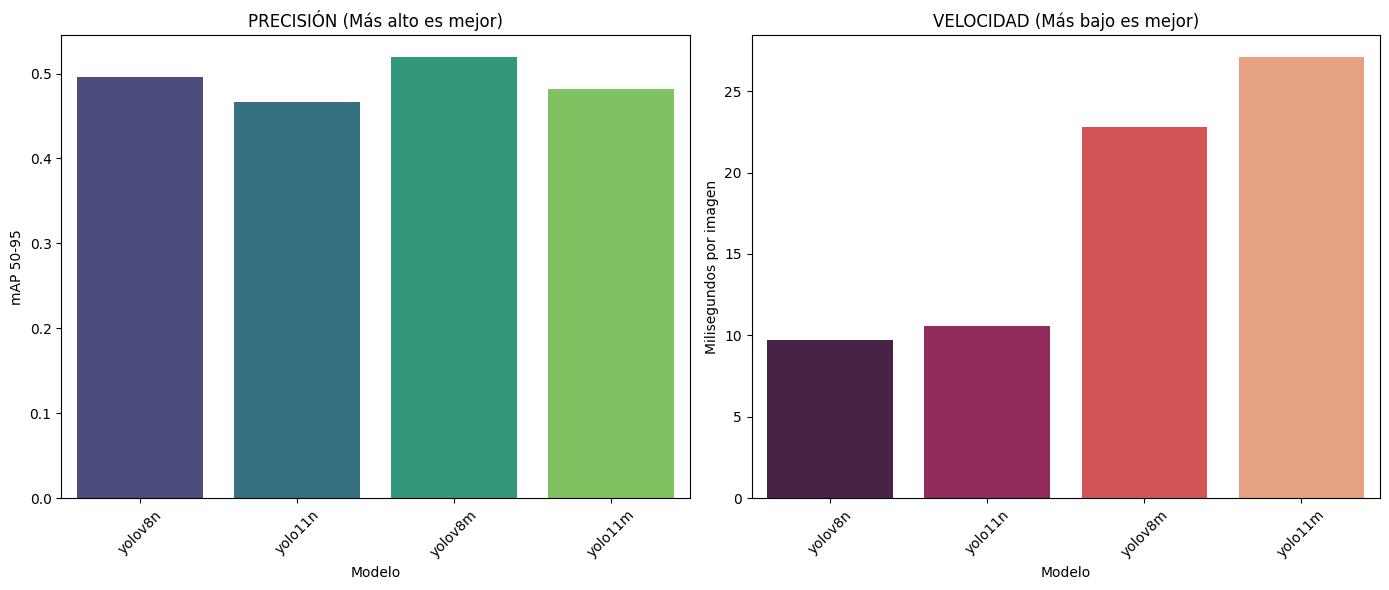

In [ ]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from google.colab import drive

# 1. MONTAR DRIVE Y PREPARAR CARPETA
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Ruta donde se guardarán los resultados finales
DRIVE_RESULTS_PATH = "/content/drive/MyDrive/YOLO_Torneo_Resultados"
os.makedirs(DRIVE_RESULTS_PATH, exist_ok=True)

print(f" Los resultados se guardarán automáticamente en: {DRIVE_RESULTS_PATH}")

# 2. LISTA DE COMPETIDORES
models_to_test = [
    'yolov8n.pt',  # V8 Nano
    'yolo11n.pt',  # V11 Nano
    'yolov8m.pt',  # V8 Medium
    'yolo11m.pt'   # V11 Medium
]

results_data = []

# 3. BUCLE DEL TORNEO
for model_name in models_to_test:
    print(f"\n ENTRENANDO: {model_name} ...")

    model = YOLO(model_name)

    # Entrenamos leyendo el dataset LOCAL (/content/yolo_mini) para máxima velocidad
    model.train(
        data='/content/yolo_mini/data.yaml',
        epochs=20,
        imgsz=640,
        batch=8,
        device=0 if torch.cuda.is_available() else 'cpu',
        project='benchmark_temp', # Guardamos los runs temporalmente en local
        name=model_name.replace('.pt', ''),
        verbose=False
    )

    # Métricas
    metrics = model.val(split='val', verbose=False)

    results_data.append({
        'Modelo': model_name.replace('.pt', ''),
        'mAP50': metrics.box.map50,
        'mAP50-95 (Alta Precisión)': metrics.box.map,
        'Velocidad (ms)': metrics.speed['inference']
    })

print("\n🏁 ¡TORNEO FINALIZADO!")

# --- 4. GUARDAR Y VISUALIZAR RESULTADOS ---
df = pd.DataFrame(results_data)

# A) GUARDAR CSV EN DRIVE
csv_path = f"{DRIVE_RESULTS_PATH}/tabla_resultados.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Tabla guardada en: {csv_path}")

print("\n TABLA DE RESULTADOS:")
print(df)

# B) GENERAR Y GUARDAR GRÁFICAS EN DRIVE
plt.figure(figsize=(14, 6))

# Gráfico 1: Precisión
plt.subplot(1, 2, 1)
sns.barplot(data=df, x='Modelo', y='mAP50-95 (Alta Precisión)', palette='viridis')
plt.title("PRECISIÓN (Más alto es mejor)")
plt.ylabel("mAP 50-95")
plt.xticks(rotation=45)

# Gráfico 2: Velocidad
plt.subplot(1, 2, 2)
sns.barplot(data=df, x='Modelo', y='Velocidad (ms)', palette='rocket')
plt.title("VELOCIDAD (Más bajo es mejor)")
plt.ylabel("Milisegundos por imagen")
plt.xticks(rotation=45)

plt.tight_layout()

# Guardar imagen ANTES de mostrarla
png_path = f"{DRIVE_RESULTS_PATH}/graficas_comparativas.png"
plt.savefig(png_path)
print(f"✅ Gráfica guardada en: {png_path}")

plt.show()

### PRUEBA Dataset Completo

Los resultados (CSV y Gráfica) se guardarán en: /content/drive/MyDrive/YOLO_Benchmark_Resultados
Dataset Completo detectado en: /content/yolo_dataset_structured

INICIANDO EVALUACION DE MODELOS (6 modelos)...
Dispositivo: Tesla T4

-------------------------------------------------
Procesando modelo: yolov8n.pt
-------------------------------------------------
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset_structured/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015,

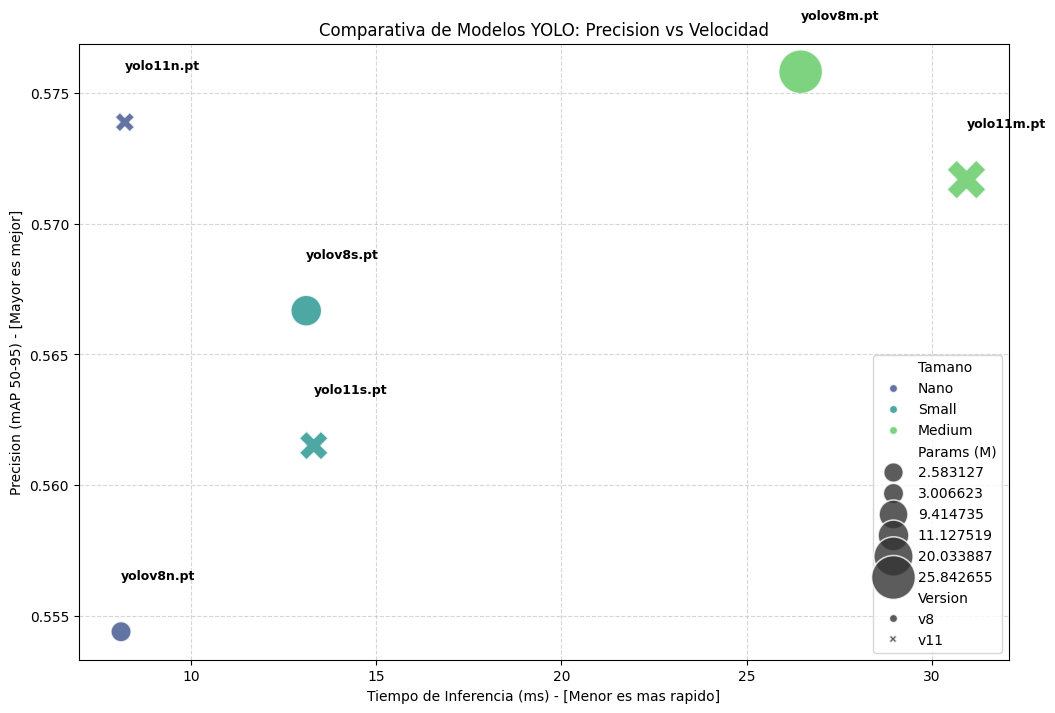

In [ ]:
import os
import gc
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from google.colab import drive

# ==========================================
# 0. CONFIGURACIÓN DE DRIVE
# ==========================================
# Montamos Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Definimos dónde guardar los resultados finales en Drive
DRIVE_OUTPUT_PATH = "/content/drive/MyDrive/YOLO_Benchmark_Resultados"
os.makedirs(DRIVE_OUTPUT_PATH, exist_ok=True)
print(f"Los resultados (CSV y Gráfica) se guardarán en: {DRIVE_OUTPUT_PATH}")

# ==========================================
# 1. CONFIGURACION: DATASET
# ==========================================
DATASET_PATH = "/content/yolo_dataset_structured"
YAML_PATH = f"{DATASET_PATH}/data.yaml"

# Verificacion de seguridad
if not os.path.exists(YAML_PATH):
    print(f"ERROR: No encuentro el archivo de configuracion en {YAML_PATH}")
    raise FileNotFoundError("data.yaml no encontrado")
else:
    print(f"Dataset Completo detectado en: {DATASET_PATH}")

# ==========================================
# 2. CONFIGURACION DE LA EVALUACION
# ==========================================
models_to_test = [
    'yolov8n.pt', 'yolo11n.pt',  # Nano
    'yolov8s.pt', 'yolo11s.pt',  # Small
    'yolov8m.pt', 'yolo11m.pt',  # Medium
]

results_data = []
device = 0 if torch.cuda.is_available() else 'cpu'

print(f"\nINICIANDO EVALUACION DE MODELOS ({len(models_to_test)} modelos)...")
print(f"Dispositivo: {torch.cuda.get_device_name(0) if device == 0 else 'CPU'}")

# ==========================================
# 3. BUCLE DE ENTRENAMIENTO
# ==========================================
for model_name in models_to_test:
    print(f"\n-------------------------------------------------")
    print(f"Procesando modelo: {model_name}")
    print(f"-------------------------------------------------")

    # Limpieza de memoria
    gc.collect()
    torch.cuda.empty_cache()

    try:
        model = YOLO(model_name)

        if 'n.pt' in model_name: bs = 32
        elif 's.pt' in model_name: bs = 16
        else: bs = 8

        # Entrenamiento (Se guarda temporalmente en Colab para velocidad)
        model.train(
            data=YAML_PATH,
            epochs=20,
            imgsz=640,
            batch=bs,
            device=device,
            project='benchmark_temp_runs',
            name=model_name.replace('.pt', ''),
            verbose=False,
            plots=False
        )

        # Validacion
        metrics = model.val(split='val', verbose=False)
        map50_95 = metrics.box.map
        speed = metrics.speed['inference'] + metrics.speed['preprocess'] + metrics.speed['loss']
        n_params = sum(p.numel() for p in model.parameters()) / 1e6

        results_data.append({
            'Modelo': model_name,
            'Tamano': 'Nano' if 'n.pt' in model_name else ('Small' if 's.pt' in model_name else 'Medium'),
            'Version': 'v11' if '11' in model_name else 'v8',
            'mAP50-95': map50_95,
            'Velocidad (ms)': speed,
            'Params (M)': n_params
        })

        print(f"Finalizado {model_name}: mAP={map50_95:.3f} | Tiempo={speed:.1f}ms")

    except Exception as e:
        print(f"Fallo en {model_name}: {e}")

# ==========================================
# 4. RESULTADOS Y GRAFICAS (GUARDADO EN DRIVE)
# ==========================================
if len(results_data) > 0:
    df = pd.DataFrame(results_data)

    print("\nTABLA DE RESULTADOS:")
    print(df.sort_values(by='mAP50-95', ascending=False)[['Modelo', 'mAP50-95', 'Velocidad (ms)', 'Params (M)']])

    # Generacion del Grafico
    plt.figure(figsize=(12, 8))

    sns.scatterplot(
        data=df,
        x='Velocidad (ms)',
        y='mAP50-95',
        hue='Tamano',
        style='Version',
        size='Params (M)',
        sizes=(200, 1000),
        palette='viridis',
        alpha=0.8
    )

    for i in range(df.shape[0]):
        plt.text(
            df['Velocidad (ms)'][i],
            df['mAP50-95'][i] + 0.002,
            df['Modelo'][i],
            fontsize=9,
            weight='bold'
        )

    plt.title("Comparativa de Modelos YOLO: Precision vs Velocidad")
    plt.xlabel("Tiempo de Inferencia (ms) - [Menor es mas rapido]")
    plt.ylabel("Precision (mAP 50-95) - [Mayor es mejor]")
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- GUARDADO EN DRIVE ---
    png_path = os.path.join(DRIVE_OUTPUT_PATH, 'benchmark_resultados.png')
    csv_path = os.path.join(DRIVE_OUTPUT_PATH, 'benchmark_resultados.csv')

    plt.savefig(png_path)
    df.to_csv(csv_path, index=False)

    print("-" * 50)
    print(f" ¡ÉXITO! Resultados guardados en Drive:")
    print(f"    CSV: {csv_path}")
    print(f"    PNG: {png_path}")
    print("-" * 50)

    plt.show()
else:
    print("No se generaron resultados debido a errores previos.")